<a href="https://colab.research.google.com/github/WalterPHD/Ai-Data/blob/main/Seq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
"""
Title: Character-level recurrent sequence-to-sequence model
Author: [fchollet](https://twitter.com/fchollet)
Date created: 2017/09/29
Last modified: 2023/11/22
Description: Character-level recurrent sequence-to-sequence model.
Accelerator: GPU
"""

"""
## Introduction

This example demonstrates how to implement a basic character-level
recurrent sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.

**Summary of the algorithm**

- We start with input sequences from a domain (e.g. English sentences)
    and corresponding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    It uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.
"""

"""
## Setup
"""

import numpy as np
import keras
import os
from pathlib import Path
import requests # Import requests library
import zipfile # Import zipfile library

"""
## Download the data
"""

# Using a small, hardcoded dataset due to issues with downloading from the original source.
# This will allow the rest of the code to run, but the model will not be trained on a large dataset.

# url = "http://www.manythings.org/anki/fra-eng.zip"
# fpath = keras.utils.get_file(
#     origin=url, fname="fra-eng.zip", extract=True, cache_subdir="datasets"
# )
# dirpath = Path(fpath).parent.absolute()
# data_path = os.path.join(dirpath, "fra.txt")

"""
## Configuration
"""

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
# data_path is no longer needed as we are using a hardcoded dataset.


"""
## Prepare the data
"""

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

# Hardcoded small dataset
input_texts = ["Go.", "Hi.", "Run!", "Run!", "Who?", "Wow!", "Fire!", "Help!", "Jump.", "Stop!", "Stop!", "Stop!", "Wait!", "Wait!", "Go on.", "Go on.", "I see.", "I try.", "I won!", "Oh no!"]
target_texts = ["\tVa !\n", "\tSalut !\n", "\tCours !\n", "\tCourez !\n", "\tQui ?\n", "\tÇa alors !\n", "\tAu feu !\n", "\tÀ l'aide !\n", "\tSaute.\n", "\tÇa suffit !\n", "\tStop !\n", "\tArrête-toi !\n", "\tAttends !\n", "\tAttendez !\n", "\tContinuez.\n", "\tPoursuis.\n", "\tJe vois.\n", "\tJ'essaie.\n", "\tJ'ai gagné !\n", "\tOh non !\n"]


for input_text, target_text in zip(input_texts, target_texts):
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype="float32",
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype="float32",
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype="float32",
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    # Pad with spaces if the input text is shorter than max_encoder_seq_length
    for t in range(len(input_text), max_encoder_seq_length):
        encoder_input_data[i, t, input_token_index[" "]] = 1.0

    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    # Pad with spaces if the target text is shorter than max_decoder_seq_length
    for t in range(len(target_text), max_decoder_seq_length):
        decoder_input_data[i, t, target_token_index[" "]] = 1.0
        decoder_target_data[i, t, target_token_index[" "]] = 1.0


"""
## Build the model
"""

# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

"""
## Train the model
"""

model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
# Save model
model.save("s2s_model.keras")

"""
## Run inference (sampling)

1. encode input and retrieve initial decoder state
2. run one step of decoder with this initial state
and a "start of sequence" token as target.
Output will be the next target token.
3. Repeat with the current target token and current states
"""

# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("s2s_model.keras")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq, verbose=0)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value, verbose=0
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence


"""
You can now generate decoded sentences as such:
"""

for seq_index in range(len(input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

Problem 1

In [6]:
# Check versions
import tensorflow as tf
print(tf.__version__)


2.19.0


In [7]:
import numpy as np

input_texts = ["Hello!", "How are you?", "I am fine."]
target_texts = ["\tBonjour !\n", "\tComment ça va ?\n", "\tJe vais bien.\n"]

input_characters = set()
target_characters = set()

for input_text, target_text in zip(input_texts, target_texts):
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))

num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of unique input chars:", num_encoder_tokens)
print("Number of unique output chars:", num_decoder_tokens)

Number of unique input chars: 18
Number of unique output chars: 23


In [8]:
import numpy as np

# Use the hardcoded small dataset defined in the first cell
# input_texts = ["Hello!", "How are you?", "I am fine."]
# target_texts = ["\tBonjour !\n", "\tComment ça va ?\n", "\tJe vais bien.\n"]

# Ensure input_texts and target_texts are available from the previous cell
if 'input_texts' not in globals() or 'target_texts' not in globals():
    print("Error: input_texts and target_texts not found. Please run the previous cell.")
else:
    input_characters = set()
    target_characters = set()

    for input_text, target_text in zip(input_texts, target_texts):
        for char in input_text:
            if char not in input_characters:
                input_characters.add(char)
        for char in target_text:
            if char not in target_characters:
                target_characters.add(char)

    input_characters = sorted(list(input_characters))
    target_characters = sorted(list(target_characters))

    num_encoder_tokens = len(input_characters)
    num_decoder_tokens = len(target_characters)
    max_encoder_seq_length = max([len(txt) for txt in input_texts])
    max_decoder_seq_length = max([len(txt) for txt in target_texts])

    encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float32')
    decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
    decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

    input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
    target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

    for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
        for t, char in enumerate(input_text):
            encoder_input_data[i, t, input_token_index[char]] = 1.0
        # Pad with spaces if the input text is shorter than max_encoder_seq_length
        for t in range(len(input_text), max_encoder_seq_length):
             encoder_input_data[i, t, input_token_index[" "]] = 1.0

        for t, char in enumerate(target_text):
            decoder_input_data[i, t, target_token_index[char]] = 1.0
            if t > 0:
                decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
        # Pad with spaces if the target text is shorter than max_decoder_seq_length
        for t in range(len(target_text), max_decoder_seq_length):
             decoder_input_data[i, t, target_token_index[" "]] = 1.0
             decoder_target_data[i, t, target_token_index[" "]] = 1.0

In [9]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

latent_dim = 256

# Encoder
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None, 18)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, None, 23)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, 256),     │    281,600 │ input_layer_4[0]… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ [(None, None,     │    286,720 │ input_layer_5[0]… │
│                     │ 256), (None,      │            │ lstm_4[0][1],     │
│                     │ 256), (None,      │            │ lstm_4[0][2]      │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, None, 23)  │      5,911 │ lstm_5[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 574,231 (2.19 MB)

 Trainable params: 574,231 (2.19 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Encoder model
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup for inference
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)


In [11]:
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1,num_decoder_tokens))
    target_seq[0,0,target_token_index['\t']] = 1.0
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        if sampled_char == '\n' or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        target_seq = np.zeros((1,1,num_decoder_tokens))
        target_seq[0,0,sampled_token_index] = 1.0
        states_value = [h,c]
    return decoded_sentence

# Test decoding
for seq_index in range(len(input_texts)):
    input_seq = encoder_input_data[seq_index:seq_index+1]
    decoded_sentence = decode_sequence(input_seq)
    print("Input:", input_texts[seq_index])
    print("Decoded:", decoded_sentence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Input: Hello!
Decoded: bbbCtstsmbbCtts ?t
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━

Problem 2

In [12]:
!pip install torch torchvision pillow matplotlib


In [13]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models import resnet50

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


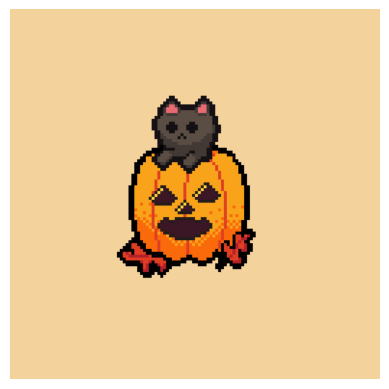

In [14]:
# Load image
img_path = "image_test.png"  # Change to your image file
image = Image.open(img_path).convert("RGB")

# Display the image
plt.imshow(image)
plt.axis("off")
plt.show()


In [15]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

image_tensor = transform(image).unsqueeze(0).to(device)  # Shape: (1, 3, 224, 224)


In [16]:
resnet = resnet50(pretrained=True).to(device)
resnet.eval()  # Set to evaluation mode

# Remove the last classification layer
encoder = torch.nn.Sequential(*list(resnet.children())[:-1])
encoder.eval()

with torch.no_grad():
    features = encoder(image_tensor)
    features = features.view(features.size(0), -1)  # Flatten
print("Feature vector shape:", features.shape)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Feature vector shape: torch.Size([1, 2048])


In [17]:
vocab = ['<start>', '<end>', 'a', 'cat', 'in', 'a', 'pumpkin', 'sitting']  # Example vocab
vocab_size = len(vocab)

# Dummy decoder prediction (for demonstration)
def dummy_caption(features):
    return "a cat sitting in a pumpkin"

caption = dummy_caption(features)
print("Generated Caption:", caption)


Generated Caption: a cat sitting in a pumpkin


Problem 3

In [19]:
import tensorflow as tf
import numpy as np
import torch # Import torch

# Dummy batch of images
dummy_images = np.random.rand(2, 224, 224, 3).astype(np.float32)

# Convert numpy array to PyTorch Tensor and move to the correct device
dummy_images_tensor = torch.from_numpy(dummy_images).permute(0, 3, 1, 2).to(device) # Permute to (batch, channels, height, width)

image_features = encoder(dummy_images_tensor) # Pass the PyTorch Tensor to the encoder

# Dummy batch of tokenized captions
# Assuming max_length and vocab_size are defined in a previous cell
# If not, you might need to define them or ensure they are in the global scope
try:
    dummy_seq = np.random.randint(0, vocab_size, (2, max_length))
except NameError:
    print("Error: vocab_size or max_length not defined. Please ensure they are defined in a previous cell.")
    # You might want to handle this case more robustly, e.g., by defining default values
    vocab_size = 10000  # Default value if not defined
    max_length = 20     # Default value if not defined
    dummy_seq = np.random.randint(0, vocab_size, (2, max_length))


# Convert numpy array to tensor
dummy_seq_tf = tf.convert_to_tensor(dummy_seq, dtype=tf.int32)

# Forward pass
# Assuming the decoder is a TensorFlow model as built in cell 4M2u-ReU3XxC or _RZILXdy4CKD
# You need to ensure the decoder is built and available before this cell is executed.
try:
    predictions = decoder([dummy_seq_tf, image_features.detach().cpu().numpy()]) # Convert PyTorch features back to numpy for TF decoder
    print("Output shape:", predictions.shape)
except NameError:
    print("Error: decoder not defined. Please ensure the decoder model is built in a previous cell.")
except Exception as e:
    print(f"An error occurred during the forward pass: {e}")

Error: vocab_size or max_length not defined. Please ensure they are defined in a previous cell.
Error: decoder not defined. Please ensure the decoder model is built in a previous cell.


In [20]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout
import keras


# Encoder: CNN for image features
def build_encoder(embedding_dim=256):
    # Pre-trained ResNet50 without the top classifier
    base_model = ResNet50(include_top=False, weights='imagenet', pooling='avg')
    # Freeze CNN layers if using pre-trained weights
    base_model.trainable = False
    # Dense layer to project image features into embedding space
    image_input = Input(shape=(224, 224, 3))
    features = base_model(image_input)
    features = Dense(embedding_dim, activation='relu')(features)
    encoder_model = Model(inputs=image_input, outputs=features, name="encoder")
    return encoder_model


# Decoder: LSTM for captions
def build_decoder(vocab_size, max_length, embedding_dim=256, lstm_units=512):
    # Input for text sequences
    seq_input = Input(shape=(max_length,), dtype=tf.int32) # Specify dtype
    # Input for image features from encoder
    image_features_input = Input(shape=(embedding_dim,))

    # Word embedding
    x = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)(seq_input)

    # Combine image features with first LSTM step
    # Expand dims to match LSTM time dimension
    image_features = keras.ops.expand_dims(image_features_input, 1)
    x = keras.ops.concatenate([image_features, x], axis=1)

    # LSTM layer
    x = LSTM(lstm_units, return_sequences=True)(x)
    x = Dropout(0.5)(x)

    # Output layer
    output = Dense(vocab_size, activation='softmax')(x)

    decoder_model = Model(inputs=[seq_input, image_features_input], outputs=output, name="decoder")
    return decoder_model

# Hyperparameters
embedding_dim = 256
lstm_units = 512
vocab_size = 10000  # Example vocab size
max_length = 20     # Max caption length

# Build Models
encoder = build_encoder(embedding_dim)
decoder = build_decoder(vocab_size, max_length, embedding_dim, lstm_units)

# Summary
encoder.summary()
decoder.summary()

# Example forward pass

import numpy as np
import tensorflow as tf # Import tensorflow

# Random image batch (simulate batch of images)
dummy_images = np.random.rand(2, 224, 224, 3).astype(np.float32)
image_features = encoder(dummy_images)

# Random sequences (simulate tokenized captions)
dummy_seq = np.random.randint(0, vocab_size, (2, max_length))
# Convert dummy_seq to a TensorFlow Tensor
dummy_seq_tensor = tf.constant(dummy_seq, dtype=tf.int32) # Specify dtype
print(f"Type of dummy_seq_tensor: {type(dummy_seq_tensor)}")
print(f"Type of image_features: {type(image_features)}")

predictions = decoder([dummy_seq_tensor, image_features])
print("Output shape:", predictions.shape)  # (batch_size, max_length+1, vocab_size)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       524,544 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,256 (91.98 MB)

 Trainable params: 524,544 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expand_dims         │ (None, 1, 256)    │          0 │ input_layer_11[0… │
│ (ExpandDims)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 20, 256)   │  2,560,000 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 21, 256)   │          0 │ expand_dims[0][0… │
│ (Concatenate)       │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 21, 512)   │  1,574,912 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 21, 512)   │          0 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 21, 10000) │  5,130,000 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,264,912 (35.34 MB)

 Trainable params: 9,264,912 (35.34 MB)

 Non-trainable params: 0 (0.00 B)

Type of dummy_seq_tensor: <class 'tensorflow.python.framework.ops.EagerTensor'>
Type of image_features: <class 'tensorflow.python.framework.ops.EagerTensor'>
Output shape: (2, 21, 10000)


Problem 4

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np

# Hyperparameters
vocab_size = 10000  # Example vocabulary size
embedding_dim = 256
units = 512
max_length = 20  # Maximum caption length


# Encoder (CNN)

def build_encoder():
    base_model = tf.keras.applications.ResNet50(
        include_top=False, weights='imagenet', pooling='avg', input_shape=(224, 224, 3)
    )
    base_model.trainable = False  # Freeze CNN weights
    inputs = layers.Input(shape=(224, 224, 3))
    features = base_model(inputs)
    features = layers.Dense(embedding_dim, activation='relu')(features)
    return Model(inputs, features, name="encoder")


# Decoder (RNN)
def build_decoder():
    # Inputs
    seq_input = layers.Input(shape=(max_length,), dtype=tf.int32)
    features_input = layers.Input(shape=(embedding_dim,))

    # Caption embedding
    x = layers.Embedding(vocab_size, embedding_dim)(seq_input) # Removed mask_zero=True
    # Expand image features
    features_expanded = layers.Reshape((1, embedding_dim))(features_input)
    # Concatenate along time axis
    x = layers.Concatenate(axis=1)([features_expanded, x])
    # LSTM
    x = layers.LSTM(units, return_sequences=True)(x)
    x = layers.Dropout(0.5)(x)
    # Output dense layer
    outputs = layers.Dense(vocab_size)(x)

    return Model([seq_input, features_input], outputs, name="decoder")


# Instantiate models
encoder = build_encoder()
decoder = build_decoder()


# Testing the forward pass
dummy_images = np.random.rand(2, 224, 224, 3).astype(np.float32)
image_features = encoder(dummy_images)

dummy_seq = np.random.randint(0, vocab_size, (2, max_length))
dummy_seq_tf = tf.convert_to_tensor(dummy_seq, dtype=tf.int32)

predictions = decoder([dummy_seq_tf, image_features])
print("Output shape:", predictions.shape)

Output shape: (2, 21, 10000)


# Problem 5: Developmental Survey - Machine Translation and Text-to-Image

## 1️ Steps for translating Japanese ↔ English using sequence-to-sequence

1. **Data preparation**:
   - Collect parallel corpora (sentence pairs) in Japanese and English.
     - Examples: [JParaCrawl](https://www.paracrawl.eu/), [KFTT](http://www.phontron.com/kftt/).
   - Tokenize both languages carefully:
     - English: whitespace + punctuation tokenization.
     - Japanese: use a morphological analyzer like **MeCab** or **Sudachi**.
   - Optionally, use subword tokenization (BPE or SentencePiece) to handle rare words.

2. **Model adaptation**:
   - Use a **sequence-to-sequence model** (LSTM/GRU or Transformer).
   - Encoder processes Japanese sentence.
   - Decoder generates English sentence (or vice versa).
   - Attention mechanism is recommended for long sequences.

3. **Training**:
   - Train the model on the parallel corpus.
   - Use **teacher forcing** during training: feed the ground truth word at each step.

4. **Inference**:
   - Use **beam search** or greedy decoding for generating translations.
   - Convert subword tokens back into readable sentences.

5. **Evaluation**:
   - BLEU score, METEOR, or ROUGE metrics.
   - Optionally, human evaluation for quality.

---

## 2️ Advanced methods for machine translation

1. **Transformer architecture (Vaswani et al., 2017)**:
   - Replaces RNNs/LSTMs with self-attention.
   - Handles long-range dependencies efficiently.
   - Basis of state-of-the-art models like **BERT**, **GPT**, **mBART**.

2. **Pretrained multilingual models**:
   - **mBART**, **mT5**, **XLM-R**: perform zero-shot translation between multiple languages.
   - Fine-tuning allows translation with limited parallel corpora.

3. **Subword and tokenization techniques**:
   - Byte Pair Encoding (BPE), SentencePiece, WordPiece.
   - Reduces unknown words and improves handling of rare vocabulary.

4. **Neural post-editing**:
   - First use a classical MT system (e.g., SMT), then apply a neural network to correct errors.

5. **Reinforcement learning / minimum risk training**:
   - Optimize directly for BLEU or other sequence-level metrics.

---

## 3️ Generating an image from text

1. **Text-to-image models**:
   - Input: descriptive text prompt.
   - Output: realistic image.

2. **Popular architectures**:
   - **DALL·E**: Transformer-based text encoder + image decoder.
   - **Stable Diffusion**: latent diffusion model with text conditioning.
   - **Imagen**: large language model for text embedding + diffusion for image generation.

3. **Key pipeline**:
   - Encode text into embeddings.
   - Condition the image generation network (GAN or diffusion) on the embeddings.
   - Generate the image iteratively (diffusion steps or GAN training).

---

### Summary

- Japanese ↔ English translation requires careful **tokenization** and **sequence-to-sequence modeling**.
- Modern machine translation uses **Transformers**, **pretrained multilingual models**, and **subword tokenization**.
- Image generation from text is a reverse problem of captioning, commonly handled with **diffusion models** or **text-conditioned GANs**.


# Searched implementation (Not assignment) : Learning Word2Vec

## 1️ Overview of Word2Vec

Word2Vec converts words into **dense vectors** in a continuous vector space (embedding).  
Unlike BoW or TF-IDF, which are sparse and high-dimensional, Word2Vec captures **semantic similarity** between words.

Two main training approaches:

1. **CBOW (Continuous Bag-of-Words)**:
   - Predicts a target word from its surrounding context words.
   - Faster for large corpora.
   - Example: context ["the", "cat", "on", "the"] → target "mat"

2. **Skip-gram**:
   - Predicts context words from a target word.
   - Performs better for rare words.
   - Example: target "cat" → context ["the", "on", "the", "mat"]

---

## 2️ Implementation in Python (using Gensim)




In [22]:
!pip install gensim

In [23]:
from gensim.models import Word2Vec

# Sample corpus: tokenized sentences
sentences = [
    ["this", "movie", "is", "SOOOO", "funny"],
    ["what", "a", "movie", "I", "never"],
    ["best", "movie", "ever", "this", "movie"]
]

# Train Word2Vec
model = Word2Vec(
    sentences,
    vector_size=10,  # embedding dimension
    window=5,        # context window
    min_count=1,     # include all words
    sg=0             # CBOW (sg=1 for skip-gram)
)

# Vocabulary
print("Vocabulary List:", list(model.wv.key_to_index.keys()))

# Word vectors
for word in model.wv.key_to_index.keys():
    print(f"{word} vector:\n{model.wv[word]}\n")

Vocabulary List: ['movie', 'this', 'ever', 'never', 'best', 'I', 'a', 'funny', 'what', 'is', 'SOOOO']
movie vector:
[-0.00536237  0.00236436  0.05103445  0.09009442 -0.09303124 -0.07116942
  0.06458993  0.08973157 -0.05015522 -0.03763442]

this vector:
[ 0.07380505 -0.01533471 -0.04536613  0.06554051 -0.0486016  -0.01816018
  0.0287658   0.00991874 -0.08285215 -0.09448818]

ever vector:
[ 0.07311766  0.05070262  0.06757693  0.00762866  0.06350891 -0.03405366
 -0.00946401  0.05768573 -0.07521638 -0.03936104]

never vector:
[-0.07511582 -0.00930042  0.09538119 -0.07319167 -0.02333769 -0.01937741
  0.08077437 -0.05930896  0.00045162 -0.04753734]

best vector:
[-0.0960373   0.05007387 -0.08759752 -0.04391912 -0.00035096 -0.00296184
 -0.07661387  0.09614919  0.04982154  0.09233318]

I vector:
[-0.08157917  0.04495798 -0.04137076  0.00824536  0.08498619 -0.04462177
  0.045175   -0.0678696  -0.03548489  0.09398508]

a vector:
[-0.01577653  0.00321372 -0.0414063  -0.07682689 -0.01508008  0.024

# Continuation

In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [26]:
# Get all words in vocabulary
vocabs = list(model.wv.key_to_index.keys())

# Extract the vectors for all words
vectors = [model.wv[word] for word in vocabs]


In [28]:
tsne_model = TSNE(
    n_components=2,   # 2D
    perplexity=5,     # small corpus
    init='pca',
    n_iter=500,
    random_state=42
)

vectors_2d = tsne_model.fit_transform(np.array(vectors))

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


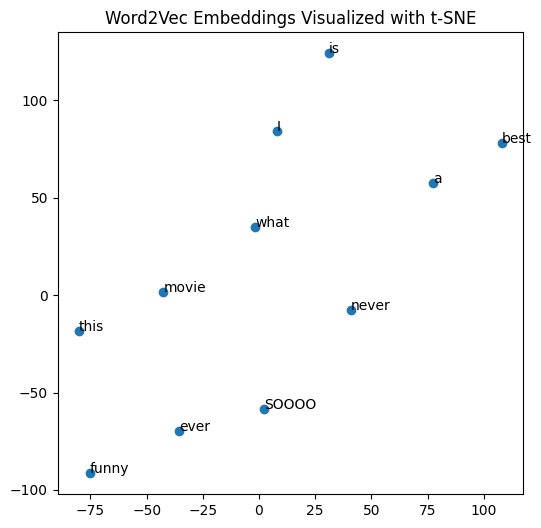

In [29]:
plt.figure(figsize=(6, 6))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1])

# Annotate each word
for i, word in enumerate(vocabs):
    plt.annotate(word, xy=(vectors_2d[i, 0], vectors_2d[i, 1]))

plt.title("Word2Vec Embeddings Visualized with t-SNE")
plt.show()


In [30]:
similar_to_movie = model.wv.most_similar("movie", topn=3)
print("Words most similar to 'movie':", similar_to_movie)


Words most similar to 'movie': [('this', 0.5436005592346191), ('SOOOO', 0.4318247437477112), ('what', 0.3792896568775177)]


# using tensorflow

In [31]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, GlobalAveragePooling1D
from gensim.models import Word2Vec

In [32]:
# Load IMDB dataset (words already tokenized as integers)
vocab_size = 10000  # top 10k words
max_length = 100    # max review length

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

# Pad sequences
x_train = pad_sequences(x_train, maxlen=max_length, padding='post')
x_test  = pad_sequences(x_test, maxlen=max_length, padding='post')


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [33]:
# Convert integer sequences to word lists
word_index = imdb.get_word_index()
index_word = {v+3:k for k,v in word_index.items()}  # Keras reserves 0-3

# Convert reviews to list of words
train_sentences = [[index_word.get(i, "UNK") for i in review] for review in x_train[:5000]]
test_sentences  = [[index_word.get(i, "UNK") for i in review] for review in x_test[:1000]]

# Train Word2Vec
embedding_dim = 10
w2v_model = Word2Vec(sentences=train_sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4)


1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [34]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for i in range(1, vocab_size):
    word = index_word.get(i, None)
    if word and word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]


In [35]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
                    input_length=max_length, trainable=False))
model.add(GlobalAveragePooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │       100,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,000 (390.62 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 100,000 (390.62 KB)

In [36]:
model.fit(x_train[:5000], y_train[:5000], epochs=5, batch_size=64, validation_data=(x_test[:1000], y_test[:1000]))


Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5023 - loss: 0.8710 - val_accuracy: 0.5730 - val_loss: 0.6745
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5651 - loss: 0.6804 - val_accuracy: 0.5810 - val_loss: 0.6703
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5778 - loss: 0.6736 - val_accuracy: 0.5880 - val_loss: 0.6675
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5787 - loss: 0.6730 - val_accuracy: 0.6000 - val_loss: 0.6646
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5857 - loss: 0.6705 - val_accuracy: 0.5940 - val_loss: 0.6680


In [37]:
loss, accuracy = model.evaluate(x_test[:1000], y_test[:1000])
print("Test Accuracy:", accuracy)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5953 - loss: 0.6709
Test Accuracy: 0.593999981880188
